In [1]:
#Logistic regression

In [2]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
%matplotlib inline

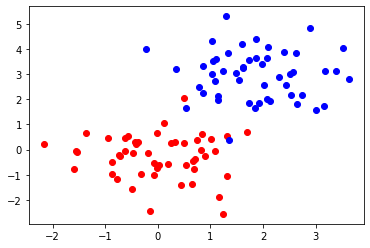

In [3]:
#Train points
c1 = [0,0]# Cluster center for class 1 data
c2 = [2,3]# Cluster center for class 2 data
n = 50 # N of samples in a class
class1 = np.matlib.repmat(c1,n,1) + np.random.randn(n,len(c1))
class2 = np.matlib.repmat(c2, n,1)+ np.random.randn(n,len(c2))
D = np.append(class1,class2,axis =0)
label = np.concatenate((np.ones((n,1)),-1*np.ones((n,1))),axis = 0)
Data = np.concatenate((D, np.ones((2*n,1))),axis = 1).T
y = label.T# Train label
plt.plot(class1[:,0],class1[:,1],'ro',class2[:,0],class2[:,1],'bo')
plt.show()

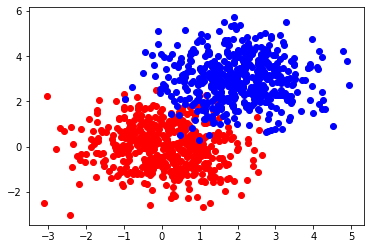

In [4]:
#Validation points
v_n = 500 # N of samples in a class
v_class1 = np.matlib.repmat(c1,v_n,1) + np.random.randn(v_n,len(c1))
v_class2 = np.matlib.repmat(c2, v_n,1)+ np.random.randn(v_n,len(c2))
v_D = np.append(v_class1,v_class2,axis =0)
v_Data = np.concatenate((v_D, np.ones((2*v_n,1))),axis = 1).T
v_label = np.concatenate((np.ones((v_n,1)),-1*np.ones((v_n,1))),axis = 0)
v_y = v_label.T# Validation label
plt.plot(v_class1[:,0],v_class1[:,1],'ro',v_class2[:,0],v_class2[:,1],'bo')
plt.show()

In [5]:
def sigmoid(x):
    a  = 1/(1+np.exp(-x))
    return a

In [6]:
def prediction(w, Data):
    pred = []
    z = np.dot(w,Data)
    a = sigmoid(z)
    for i in range(0,len(a[0])):
        if (a[0][i] > 0.5): 
            pred.append(1)
        elif (a[0][i] <= 0.5):
            pred.append(-1)
    return pred

In [7]:
learning_rate = 0.01
w = np.random.randn(1,3)
for i in range(1,1500):
    z = np.dot(w,Data)
    y_pred = prediction(w, Data)
    val = -np.multiply(y,z)
    J = np.sum(np.log(1+np.exp(val)))
    num = -np.multiply(y,np.exp(val))
    den = 1+np.exp(val)
    f = num/den
    gradJ = np.dot(Data,f.T)
    w = w - learning_rate*gradJ.T

In [8]:
Test_predict = prediction(w, v_Data)
print("Model parameters", w)
print("Test Accuracy",np.mean(v_y[0]==Test_predict)*100)

Model parameters [[-2.83625521 -2.93328989  6.56024425]]
Test Accuracy 96.6


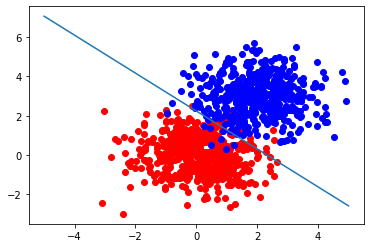

In [9]:
x =  np.linspace(-5,5,100)
h_x = -(w[0,0]/w[0,1])*x - (w[0,2]/w[0,1])
plt.plot(v_class1[:,0],v_class1[:,1],'ro',v_class2[:,0],v_class2[:,1],'bo')
plt.plot(x,h_x)
plt.show()

In [10]:
#Decision tree with CART

In [11]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
    # count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
        score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
    return gini

# Select the best split point for a dataset
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

# Create a terminal node value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

# Build a decision tree
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

# Print a decision tree
def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))

# Make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

# Classification and Regression Tree Algorithm
def decision_tree(train, test, max_depth, min_size):
    tree = build_tree(train, max_depth, min_size)
    predictions = list()
    for row in test:
        prediction = predict(tree, row)
        predictions.append(prediction)
    return(predictions)

DataTrain = np.concatenate((D, label),axis = 1)
print("Test Accuracy",np.mean(v_y[0]==decision_tree(DataTrain, v_Data[0:2].T, 5, 1))*100)

Test Accuracy 91.7
